# Code embedding using Keras

In [1]:
#TODO add keras history plot

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
font = {'weight': 'bold', 'size': 20}
plt.rc('font', **font)

## Load data

In [4]:
!ls ../data/

code-jam             crypto-competitions  others
combine_json.py      crypto-library       test.json
create_train_test.py full_data.json       train.json


In [5]:
dataframe = pd.read_json('../data/train.json')

In [6]:
dataframe.head(2)

,data_source,label,file_name,is_header,content
0,crypto-library,1,/Users/red/Documents/CP/crypto_code_detection/...,False,/* primegen.c - prime number generator\n * Cop...
1,others,0,c_impl.c,False,"#include <stdio.h>\n\nfloat f (char *str, int ..."


In [7]:
'{:,}'.format(len(dataframe))

'9,136'

Target value:

In [8]:
dataframe.label.value_counts()

0    8045
1    1091
Name: label, dtype: int64

Remove comments:

In [9]:
import re
def remove_comments(text):
    return re.sub(re.compile('#.*?\n'), '', text)

Grab docs (code submissions) and labels (correct or not):

In [10]:
def get_docs_and_labels(df):
    _docs = []
    _labels = []
    for index in df.index:
        # Program
        
        code = remove_comments(
            df.at[index, 'content']
        )
        _docs.append(code)
        # Label
        label = int(df.at[index, 'label'])
        _labels.append(label)
    return _docs, _labels

In [11]:
docs, labels = get_docs_and_labels(dataframe)

In [12]:
'{:,}'.format(len(docs))

'9,136'

## Tokenize code and generate sequences

In [91]:
import os
#To ignore the warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.preprocessing.text import Tokenizer

In [14]:
#We set the size of the vocabulary
NUM_WORDS = 10000

In [15]:
tokenizer = Tokenizer(num_words=NUM_WORDS, 
                     filters='\t\n,', 
                     lower=True, 
                     split=' ', 
                     char_level=False)

In [16]:
tokenizer.fit_on_texts(docs)

In [20]:
# Size of the vocabulary
len(tokenizer.word_index) 

1018030

In [21]:
# document_count: an integer count of the total number of documents that were used to fit the Tokenizer.
'Number docs: {:,}'.format(tokenizer.document_count)

'Number docs: 9,136'

In [25]:
# Number of occurences of if in the dataset
tokenizer.word_counts['if'] # index

118738

In [26]:
# word_docs: a dictionary of words and how many documents each appeared in.
tokenizer.word_docs['if']

5700

In [27]:
sequences = tokenizer.texts_to_sequences(docs)

Let's look at the length distribution of the sequences to know what max size to choose

In [28]:
len_seqs = [len(s) for s in sequences]
np.mean(len_seqs), np.std(len_seqs), np.max(len_seqs)

(676.5847197898424, 6083.597087715432, 498976)

The mean is at 600 but the standard deviation is much bigger

In [29]:
MAX_LENGTH = 1000

Dictionary to transform a vector back to the program:

In [31]:
id_to_word = { v: k for k, v in tokenizer.word_index.items() }

In [32]:
id_to_word[1]

'='

In [33]:
[id_to_word[index] for index in sequences[0]][0:10]

['/*',
 '-',
 'prime',
 'number',
 'generator',
 '*',
 'copyright',
 '(c)',
 '1998',
 '2000']

Pad documents:

In [35]:
from keras.preprocessing.sequence import pad_sequences
# pad documents
padded_docs = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

In [36]:
padded_docs[0][0:10]

array([  94,  256,   24,  592,  161, 2872,  109,  603,  364,   19],
      dtype=int32)

## Defining the model

In [37]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.layers.embeddings import Embedding

#We add the epsilon to avoid any error in the function

def precision_(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def recall_(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    
    precision = precision_(y_true, y_pred)
    recall = recall_(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f2(y_true, y_pred):
    
    precision = precision_(y_true, y_pred)
    recall = recall_(y_true, y_pred)
    return 5*((precision*recall)/(4*precision+recall+K.epsilon()))

In [92]:
# define the model
model = Sequential()
model.add(Embedding(NUM_WORDS, 50, input_length=MAX_LENGTH))
model.add(Flatten())
model.add(Dropout(rate=0.3))
model.add(Dense(1, activation='sigmoid'))
    
model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['acc', f1,f2,precision_,recall_])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 50)          500000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 50001     
Total params: 550,001
Trainable params: 550,001
Non-trainable params: 0
_________________________________________________________________
None


In [94]:
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
    acc = history.history['recall_']
    val_acc = history.history['val_recall_']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the number of epochs
    epochs = range(len(acc))

    plt.title('Training and validation recall')
    plt.plot(epochs, acc, color='blue', label='Train')
    plt.plot(epochs, val_acc, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.savefig('../code_embedding/plots/training_recall.png')

    _ = plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('../code_embedding/plots/training_loss.png')

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, 
                                                    test_size=0.2, random_state=0,
                                                    stratify=labels)

In [41]:
# fit the model

history = model.fit(X_train, 
          y_train,
          epochs=5,
          validation_data=(X_test,y_test))


Train on 7308 samples, validate on 1828 samples
Epoch 1/5
7308/7308 [==============================] - 34s 5ms/step - loss: 0.1724 - acc: 0.9391 - f1: 0.5685 - f2: 0.5311 - precision_: 0.6881 - recall_: 0.5132 - val_loss: 0.0879 - val_acc: 0.9710 - val_f1: 0.8761 - val_f2: 0.8477 - val_precision_: 0.9587 - val_recall_: 0.8342
Epoch 2/5
7308/7308 [==============================] - 33s 5ms/step - loss: 0.0416 - acc: 0.9877 - f1: 0.9245 - f2: 0.9089 - precision_: 0.9640 - recall_: 0.9011 - val_loss: 0.0647 - val_acc: 0.9743 - val_f1: 0.8832 - val_f2: 0.8498 - val_precision_: 0.9743 - val_recall_: 0.8324
Epoch 3/5
7308/7308 [==============================] - 30s 4ms/step - loss: 0.0207 - acc: 0.9947 - f1: 0.9586 - f2: 0.9496 - precision_: 0.9796 - recall_: 0.9448 - val_loss: 0.0640 - val_acc: 0.9765 - val_f1: 0.8981 - val_f2: 0.8725 - val_precision_: 0.9671 - val_recall_: 0.8597
Epoch 4/5
7308/7308 [==============================] - 31s 4ms/step - loss: 0.0136 - acc: 0.9955 - f1: 0.9719 -

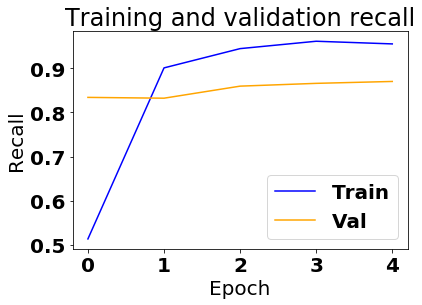

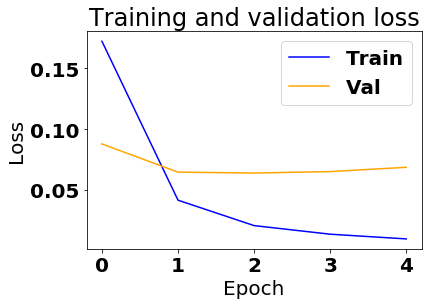

In [95]:
plot(history)

In [49]:
# evaluate the model
word_loss, word_accuracy, word_f1,word_f2, word_precision, word_recall = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f, F1: %f, F2: %f, precision: %f, recall: %f' % (word_accuracy * 100, word_f1 * 100, word_f2 * 100, word_precision*100, word_recall*100))

1828/1828 [==============================] - 0s 134us/step
Accuracy: 97.866523, F1: 90.773523, F2: 88.289410, precision: 97.627258, recall: 87.034070


In [50]:
word_score = {
    'accuracy': word_accuracy,
    'F1': word_f1,
}
embeddings_scores = { 'Word': word_score }

In [51]:
# Embedding Layer
embedding_layer = model.layers[0]
embeddings = embedding_layer.get_weights()[0]
print('Embedding Layer shape:', embeddings.shape)

Embedding Layer shape: (10000, 50)


In [53]:
embeddings[0]

array([-0.01019043,  0.00892705,  0.00377948,  0.01425829, -0.00871433,
        0.00306704, -0.00918286,  0.00097931,  0.0040127 ,  0.013565  ,
       -0.00425302, -0.0052161 , -0.00862036, -0.00722023, -0.00156455,
       -0.01795339,  0.00354832,  0.0112764 , -0.00245505, -0.00457695,
       -0.00099376,  0.00927168, -0.0001878 , -0.00337326,  0.00763401,
        0.01480659, -0.00526338, -0.01619574,  0.00541916, -0.00579271,
       -0.00725106, -0.01573423, -0.00017444, -0.00075006,  0.00521573,
       -0.0028294 , -0.00829395, -0.00076512,  0.01852327, -0.0108064 ,
        0.00495562, -0.00108177, -0.00389996, -0.00361246, -0.0016657 ,
        0.01454629,  0.00444561, -0.0026439 ,  0.01163877,  0.00895038],
      dtype=float32)

In [54]:
np.save('../code_embedding/embedding/word_embeddings', embeddings)

In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings)
print('PCA explained variance ratio:', pca.explained_variance_ratio_, 'Total:', sum(pca.explained_variance_ratio_))

PCA explained variance ratio: [0.37556496 0.03124981] Total: 0.406814768910408


In [62]:
def get_top_words(tokenizer, N=50):
    
    return [word for word, occurrences in sorted(tokenizer.word_counts.items(), key=lambda t: t[1], reverse=True)[:N]]

In [63]:
top_words = get_top_words(tokenizer)

In [71]:
def plot_embeddings(low_dim_embs, id_to_word, top_words,id_plot, figsize=(8, 8)):

    plt.figure(figsize=figsize, dpi=100)
    #ax = plt.axes()
    #ax.yaxis.set_major_locator(plt.NullLocator())
    #ax.xaxis.set_major_locator(plt.NullLocator())
    i = 0
    while i < len(low_dim_embs):

        if i in id_to_word:
            
            x, y = low_dim_embs[i, :]
            word = id_to_word[i]

            if word in top_words:
                plt.scatter(x, y, color='b')
                plt.annotate(word,
                            xy=(x, y),
                            xytext=(5, 2),
                            textcoords='offset points',
                            ha='right',
                            va='bottom',
                            fontsize=14)
                plt.title("Embedding projected on PCA space")
        
        i += 1
    plt.savefig('../code_embedding/plots/pca_{}.png'.format(id_plot))

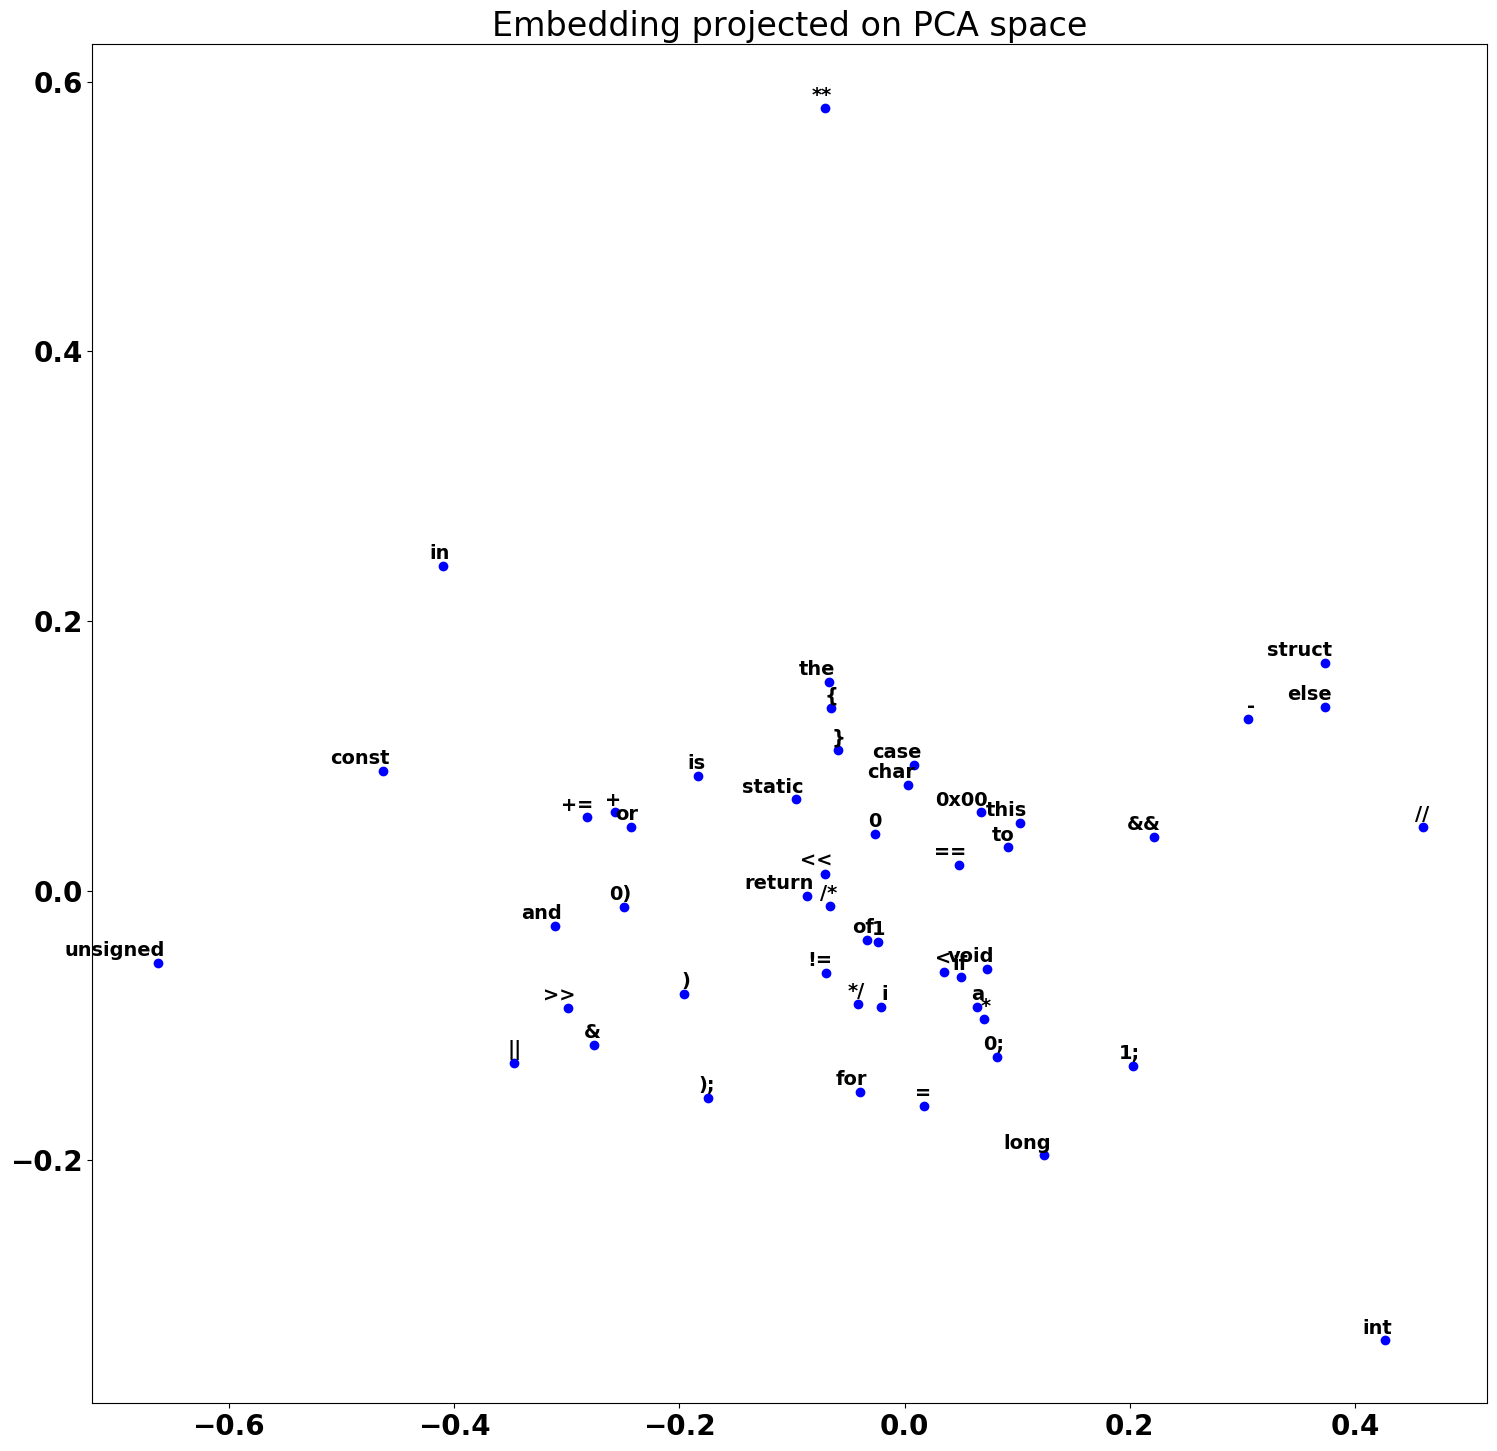

In [72]:
plot_embeddings(principal_components, id_to_word, top_words,id_plot=0, figsize=(18, 18))

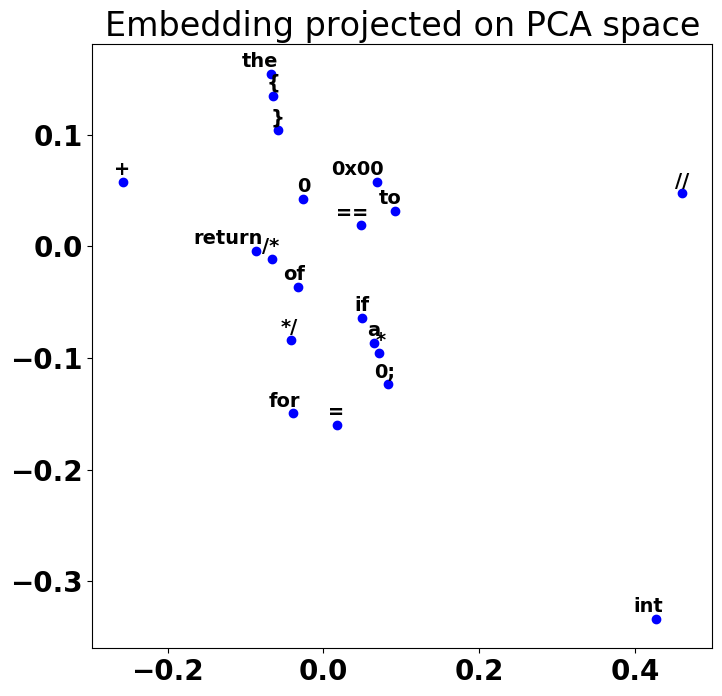

In [75]:
plot_embeddings(principal_components, id_to_word, get_top_words(tokenizer, 20), id_plot=1)

Measure the distance between vectors:

In [76]:
from scipy.spatial.distance import euclidean, cosine

def get_vector_distance(embeddings, tok, word1, word2):
    
    return euclidean(embeddings[tok.word_index[word1]], 
                     embeddings[tok.word_index[word2]])
    
def get_vector_cosine_distance(embeddings, tok, word1, word2):
    
    return cosine(embeddings[tok.word_index[word1]], 
                  embeddings[tok.word_index[word2]])

Cosine similarity:

In [79]:
get_vector_cosine_distance(embeddings, tokenizer, 'x', 'y')

0.6060374975204468

In [80]:
get_vector_cosine_distance(embeddings, tokenizer, '<<', '=')

1.1599316596984863

In [81]:
get_vector_cosine_distance(embeddings, tokenizer, '+', '-')

1.412729263305664

In [82]:
get_vector_cosine_distance(embeddings, tokenizer, '(', ')')

1.3210677802562714

In [83]:
get_vector_cosine_distance(embeddings, tokenizer, '{', '}')

1.1617834717035294

Euclidean distance:

In [84]:
get_vector_distance(embeddings, tokenizer, '<<', '>>')

0.3866688311100006

In [85]:
get_vector_distance(embeddings, tokenizer, 'x', 'y')

0.3599841594696045

In [86]:
get_vector_distance(embeddings,tokenizer, 'if', 'elif')

0.37902575731277466

In [87]:
get_vector_distance(embeddings, tokenizer, 'elif', 'else:')

0.2895454466342926

In [88]:
get_vector_distance(embeddings, tokenizer, '+', '-')

0.7345585823059082

In [89]:
get_vector_distance(embeddings, tokenizer, 'for', 'while')

0.5146770477294922

## More complex architecture

In [90]:
from keras.layers import Conv1D, BatchNormalization, Dropout, MaxPooling1D
from sklearn.metrics import f1_score

model = Sequential()
model.add(Embedding(NUM_WORDS, 50, input_length=MAX_LENGTH))
model.add(Conv1D(32, 15, strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Conv1D(32,15, strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Conv1D(32,10, strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Conv1D(32,10, strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['acc', f1,f2,precision_,recall_])

print(model.summary())
                    


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 50)          500000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 986, 32)           24032     
_________________________________________________________________
batch_normalization_1 (Batch (None, 986, 32)           128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 493, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 479, 32)           15392     
_________________________________________________________________
batch_normalization_2 (Batch (None, 479, 32)           128       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 239, 32)         